# Image Classification of different Dishes using TensorFlow

This notebook will demonstrate how Tensorflow can be used to set up a classification problem based on 101 different food dishes. The food images can be found at (https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

Let's first start by importing the relevant libraries:

In [ ]:
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report


In [2]:
image_dir = './food-101/images/'

Now let's create a Pandas DataFrame to append which image is considered what dish:

In [4]:
all_dishes_list = []

for root,dirs,files in os.walk(image_dir):
    for file in files:
        if '.jpg' in file:
            label = os.path.split(root)[1]
            food_item = {"Absolute Path":os.path.join(root,file),
                         "File Name":[file],
                         "Food Type":label}
            all_dishes_list.append(food_item)
            
all_dishes_df = pd.concat(
            [pd.DataFrame.from_dict(i) for i in all_dishes_list],ignore_index = True)

# Reduce training set by 50% across all food types to speed up model fitting
all_dishes_df = (
    all_dishes_df
    .groupby("Food Type", group_keys=False)
    .apply(lambda x: x.sample(frac=0.5, random_state=42))
    .reset_index(drop=True)
)

C:\Users\super\AppData\Local\Temp\ipykernel_24500\1174638886.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.5, random_state=42))


#### Save the DataFrame

Run this cell if you don't want to append all files to a DataFrame again

In [5]:
all_dishes_df.to_csv('./all_dishes_df.csv')

#### Pre-Load the DataFrame

Run this cell if you don't want to append all files to a DataFrame again

In [ ]:
all_dishes_df = pd.read_csv('./input_files/all_dishes_df.csv',index_col = 0,header = 0)

Assuming the DataFrame is generated/loaded properly, let's look at its structure:

In [4]:
print(all_dishes_df.shape)
all_dishes_df.head()

(50500, 3)


,Absolute Path,File Name,Food Type
0,./food-101/images/apple_pie\2967700.jpg,2967700.jpg,apple_pie
1,./food-101/images/apple_pie\1581853.jpg,1581853.jpg,apple_pie
2,./food-101/images/apple_pie\1375404.jpg,1375404.jpg,apple_pie
3,./food-101/images/apple_pie\2153869.jpg,2153869.jpg,apple_pie
4,./food-101/images/apple_pie\1626685.jpg,1626685.jpg,apple_pie


In [5]:
all_dishes_df.tail()

,Absolute Path,File Name,Food Type
50495,./food-101/images/waffles\3057857.jpg,3057857.jpg,waffles
50496,./food-101/images/waffles\2981788.jpg,2981788.jpg,waffles
50497,./food-101/images/waffles\2121986.jpg,2121986.jpg,waffles
50498,./food-101/images/waffles\3032387.jpg,3032387.jpg,waffles
50499,./food-101/images/waffles\1572031.jpg,1572031.jpg,waffles


In [6]:
counts = all_dishes_df['Food Type'].value_counts()
counts

Food Type
apple_pie        500
miso_soup        500
peking_duck      500
panna_cotta      500
pancakes         500
                ... 
donuts           500
deviled_eggs     500
cup_cakes        500
croque_madame    500
waffles          500
Name: count, Length: 101, dtype: int64

### Training and Testing the Data ###

Now let's create a training and test split. For starters, we'll use the typical values (70% training size, 30% testing size). As for the actual type of model, this is a MobileNetV2 convolutional neural network (CNN). I'm choosing MobileNetV2 due to its efficiency for image classification and other computer vision tasks.

In [7]:
train_df, test_df = train_test_split(all_dishes_df, train_size=0.7, shuffle=True, random_state=1)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Absolute Path',
    y_col='Food Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Absolute Path',
    y_col='Food Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Absolute Path',
    y_col='Food Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=False
)

Found 28280 validated image filenames belonging to 101 classes.
Found 7070 validated image filenames belonging to 101 classes.
Found 15150 validated image filenames belonging to 101 classes.


Now that we've effectively segmented the datasets into a training, validation, and testing splits, now we can input them into the MobileNetV2 CNN:

In [9]:
# Construct the base model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
# prevent weights of MobileNetV2 from updating weights
pretrained_model.trainable = False

In [11]:
inputs = pretrained_model.input
x = pretrained_model.output

# First FC block
x = tf.keras.layers.Dense(256, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

# Second FC block
x = tf.keras.layers.Dense(128, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

# Output layer
outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [29]:
#model.summary()

In [12]:
## Compile model ##

# lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


## Add callbacks to improve model performance ##
# prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

#Save model to disk
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_mobilenet_food101.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
# reduce learning rate if validation performance stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,      # reduce LR by 70%
    patience=2,      # after 2 bad epochs
    min_lr=1e-4,
    verbose=1
)

callbacks = [early_stopping, checkpoint, reduce_lr]

## Train model ##
history = model.fit(
    train_images,              # generator from subset="training"
    validation_data=val_images, # generator from subset="validation"
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
221/221 [==============================] - ETA: 0s - loss: 3.4212 - accuracy: 0.2358
Epoch 1: val_loss improved from inf to 2.45918, saving model to best_mobilenet_food101.h5
221/221 [==============================] - 577s 3s/step - loss: 3.4212 - accuracy: 0.2358 - val_loss: 2.4592 - val_accuracy: 0.4215 - lr: 0.0010
Epoch 2/10
221/221 [==============================] - ETA: 0s - loss: 2.4083 - accuracy: 0.4086
Epoch 2: val_loss improved from 2.45918 to 2.07107, saving model to best_mobilenet_food101.h5
221/221 [==============================] - 547s 2s/step - loss: 2.4083 - accuracy: 0.4086 - val_loss: 2.0711 - val_accuracy: 0.4881 - lr: 0.0010
Epoch 3/10
221/221 [==============================] - ETA: 0s - loss: 2.0759 - accuracy: 0.4719
Epoch 3: val_loss improved from 2.07107 to 1.93592, saving model to best_mobilenet_food101.h5
221/221 [==============================] - 571s 3s/step - loss: 2.0759 - accuracy: 0.4719 - val_loss: 1.9359 - val_accuracy: 0.5075 - lr: 0.0010

### Importing Model via H5 file

#### **Note:**
Run this line of code if you don't want to do the training routine again

In [ ]:
model = tf.keras.models.load_model("./input_files/best_mobilenet_food101.h5")

### Results ###

Now let's look at how our model performed:

In [13]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 54.86%


Ok now that we know that our classification model performs slightly better than a coin flip, let's generate a confusion matrix to see which food types performed the best, and which ones performed the worst:

In [14]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, 
                            target_names=test_images.class_indices,
                            output_dict = True,
                            zero_division=0)


119/119 [==============================] - 238s 2s/step


#### Save the Confusion Matrix

Run this cell if you don't want to generate the confusion matrix again

In [15]:
np.save('./input_files/confusion_matrix.npy',cm)

#### Load the Confusion Matrix

Run this cell if you don't want to generate the confusion matrix again

In [ ]:
cm = np.load('./input_files/confusion_matrix.npy')

#### Save the Classification Report DataFrame

In [ ]:
report_df = pd.DataFrame(clr).transpose()

In [22]:
report_df.to_csv('./input_files/cls_report.csv')

#### Load the Classification Report

In [ ]:
report_df = pd.read_csv('./input_files/cls_report.csv')

Now let's plot the confusion matrix

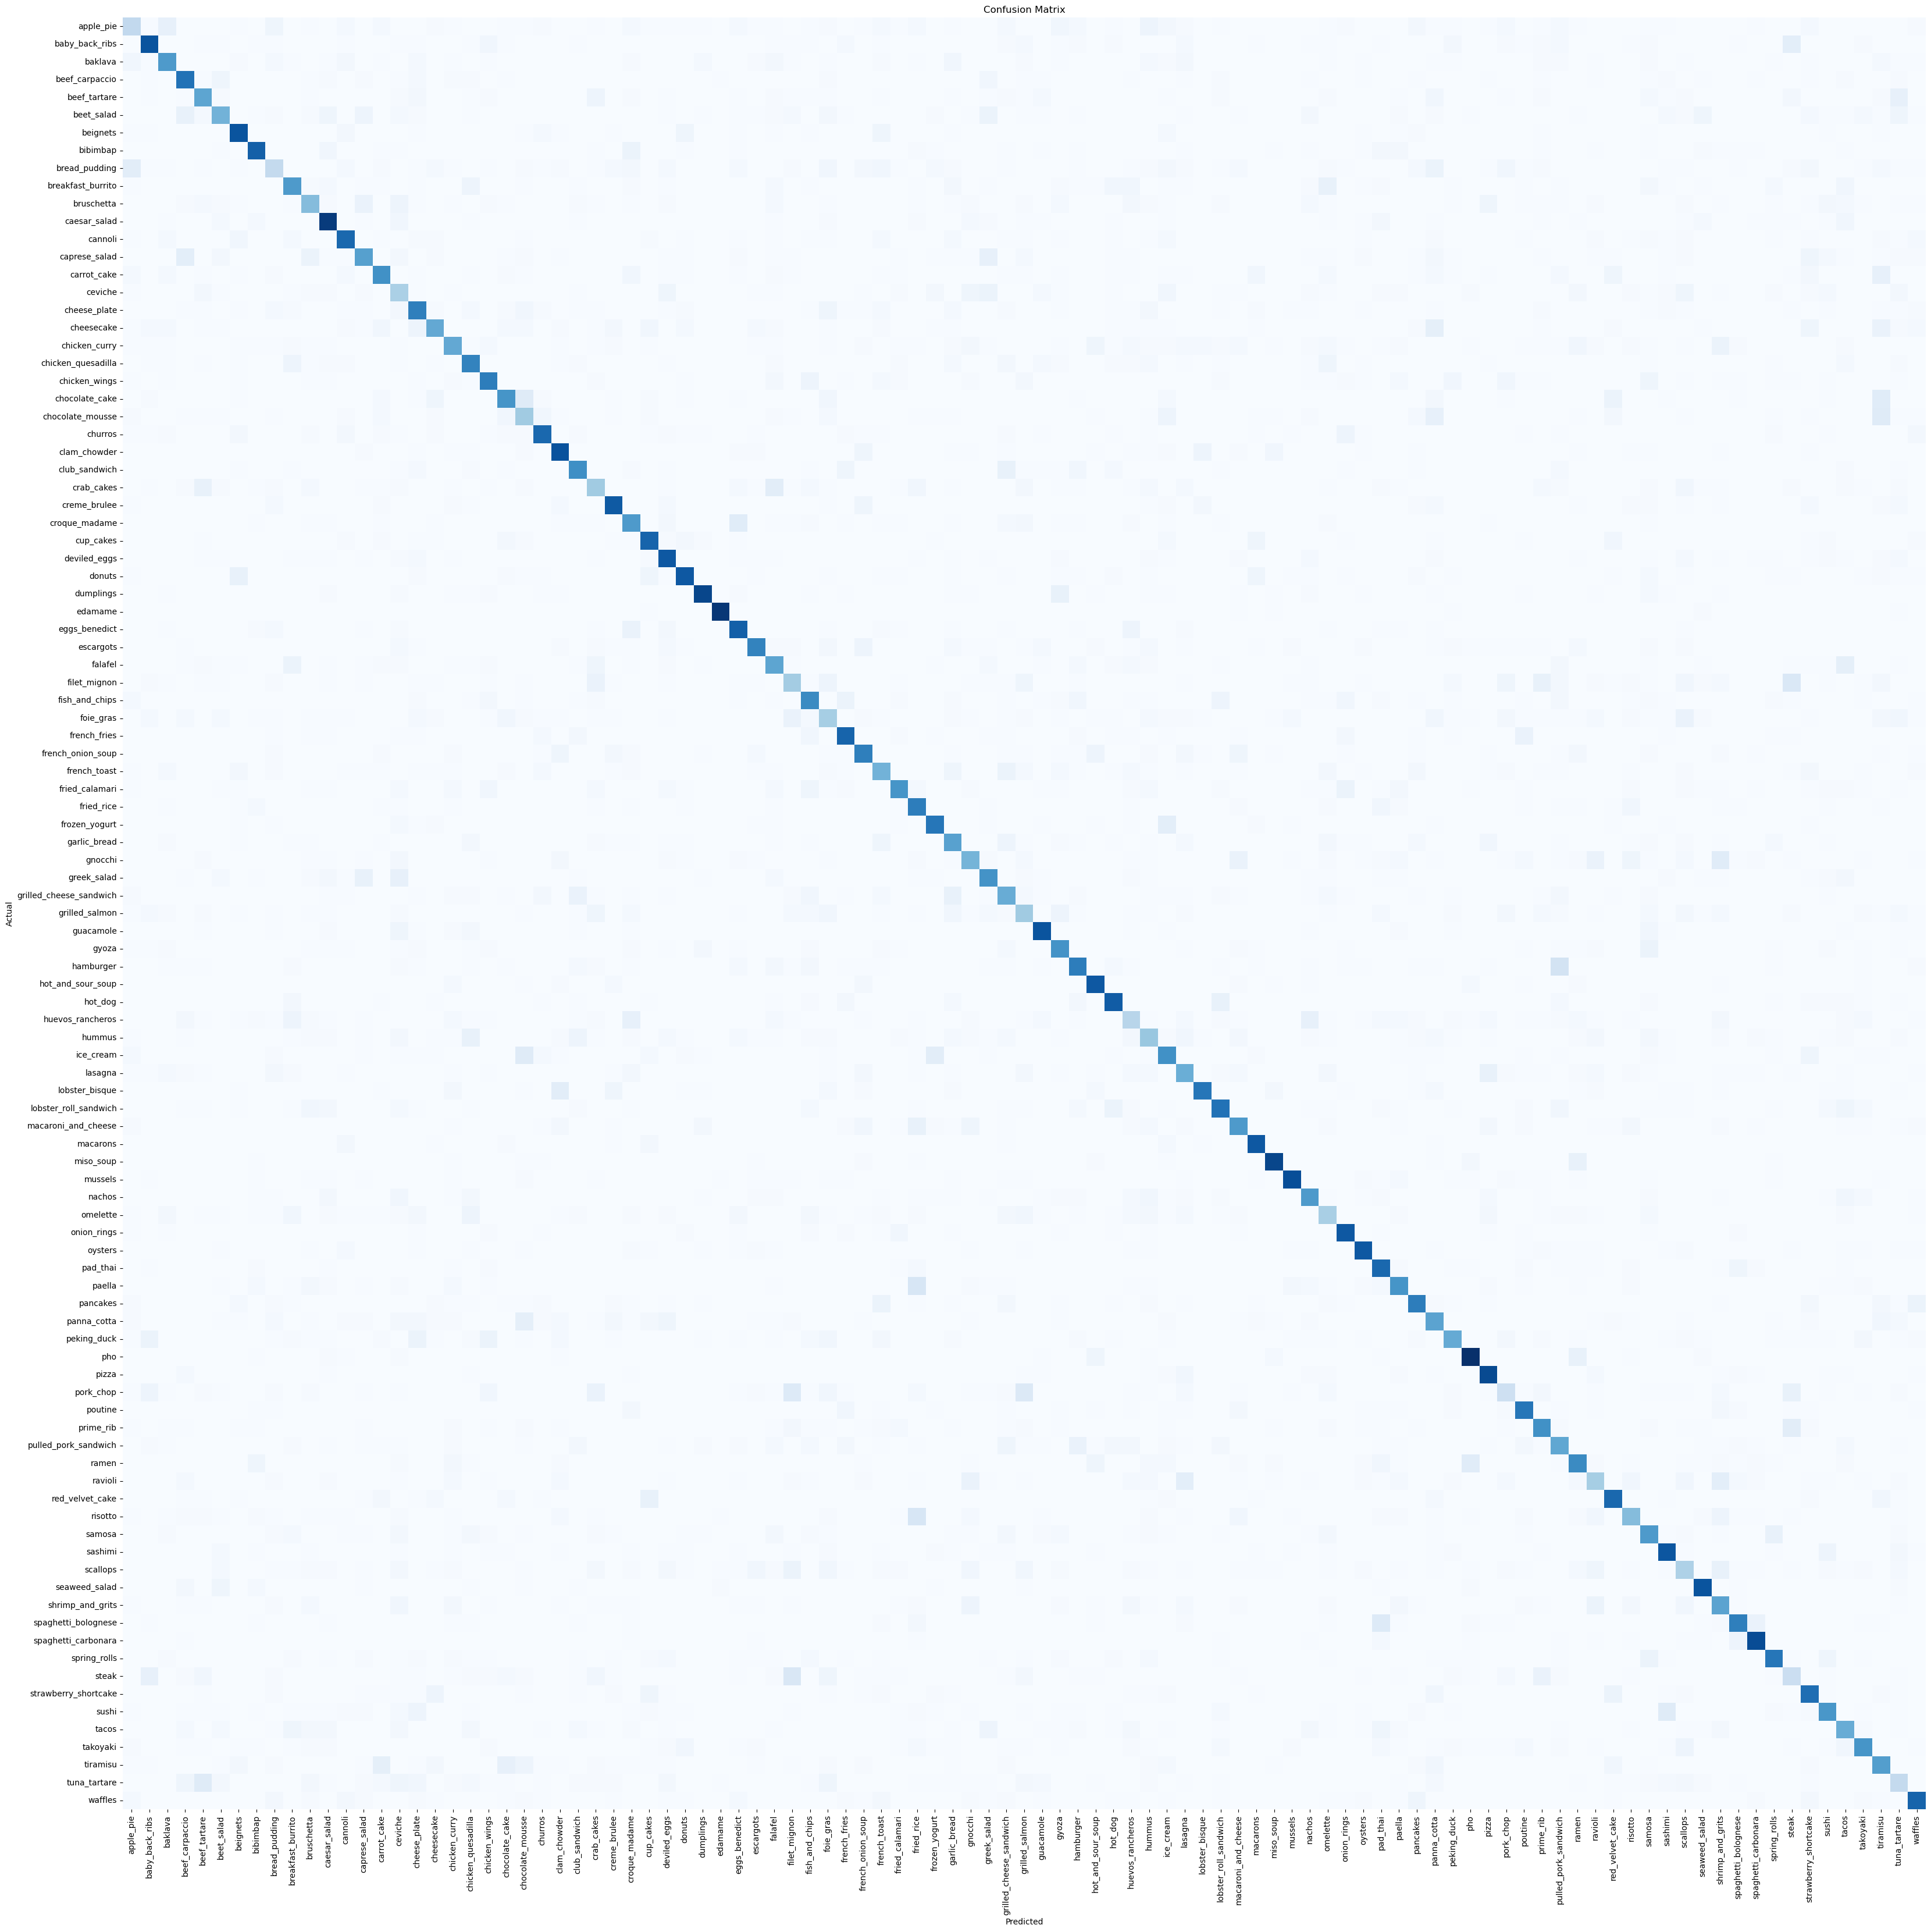

In [17]:
idx_to_class = {v: k for k, v in test_images.class_indices.items()}
labels = [idx_to_class[i] for i in range(len(idx_to_class))]
plt.figure(figsize=(40,40))
sns.heatmap(cm, annot=False, fmt='g', cmap='Blues', cbar=False)

plt.xticks(
    ticks=np.arange(101) + 0.5,
    labels=labels,
    rotation=90
)

plt.yticks(
    ticks=np.arange(101) + 0.5,
    labels=labels,
    rotation=0
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('./output_files/confusion_matrix.jpg',dpi = 200,bbox_inches = 'tight')
plt.show()

Based on this confusion matrix, we can see that our model predicted the correct food (diagonal line), but there are some instances where the model is unable to distinguish specific food items consistently (e.g.: tuna tatare vs. beef tatare). Now let's look at which food types the model was able to easily distinguish versus not easily able to distinguish based on the F1 scores:

In [18]:
fil_report_df = report_df.iloc[:-3,:]
top5 = report_df.nlargest(5, 'f1-score')
bottom5 = report_df.nsmallest(5, 'f1-score')
top5['Food Type'] = top5.index
bottom5['Food Type'] = bottom5.index

C:\Users\super\AppData\Local\Temp\ipykernel_24772\1511663131.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\super\AppData\Local\Temp\ipykernel_24772\1511663131.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


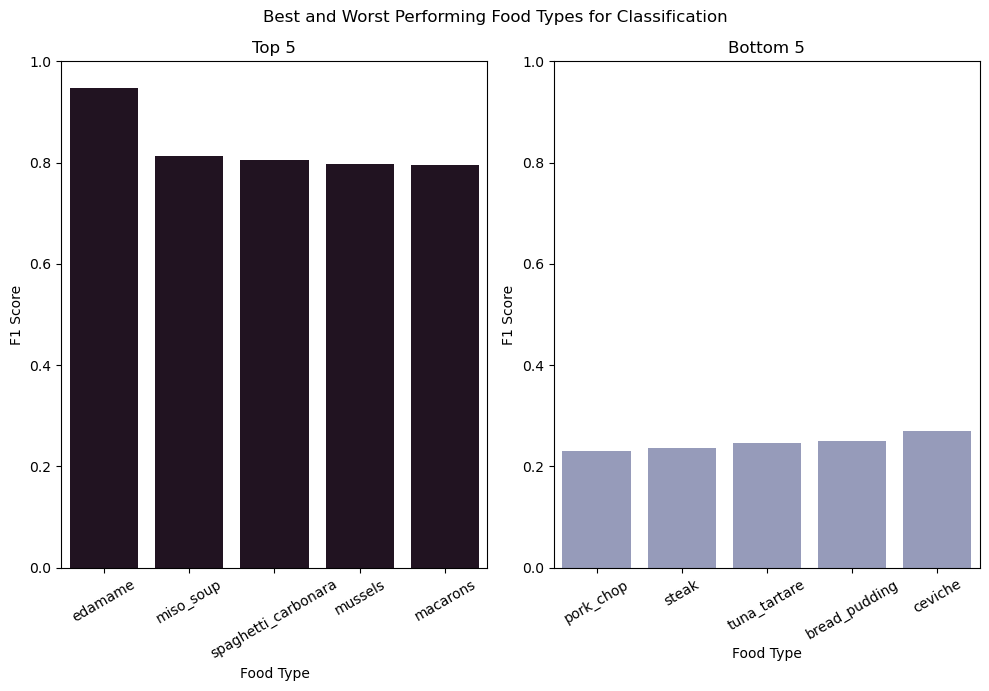

In [19]:
fig,axes = plt.subplots(figsize=(10,7),ncols = 2)
sns.barplot(data=top5, x='Food Type', y='f1-score', color = '#231123',ax = axes[0])
sns.barplot(data=bottom5, x='Food Type', y='f1-score', color='#9097C0',ax = axes[1])
indiv_fig_titles = ['Top 5','Bottom 5']
for i,ax in enumerate(axes):
    ax.set_yticks(np.arange(0,1.1,0.2))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    ax.set_title(indiv_fig_titles[i])
    ax.set_xlabel('Food Type')
    ax.set_ylabel('F1 Score')
fig.suptitle("Best and Worst Performing Food Types for Classification")
plt.tight_layout()
plt.savefig('./output_files/best_worst_food.jpg',dpi = 200,bbox_inches = 'tight')
plt.show()

Based on these bar plots, the easiest foods to distinguish are: edamame, miso soup, spaghetti carbonara, seafood salad, and dumplings. Conversely, steak, tuna tartare, scallops, huevos rancheros, and foie gras are the hardest to distinguish. So let's look into why some of these foods do not do well with classification.

Let's start by looking into the top 5 dishes most confused with tuna tartare:

In [20]:
# Index to names mapping (if not already created)
idx_to_class = {v: k for k, v in test_images.class_indices.items()}

# Get the index for "tuna_tartare"
tuna_idx = test_images.class_indices['tuna_tartare']

# Extract the row from the confusion matrix
tuna_row = cm[tuna_idx].copy()

# Remove the diagonal (correct predictions)
tuna_row[tuna_idx] = 0

# Find the class most confused with tuna tartare
confused_idx = np.argmax(tuna_row)
confused_class = idx_to_class[confused_idx]

print("Tuna tartare is most often confused with:", confused_class)
print("Number of confusions:", tuna_row[confused_idx])

Tuna tartare is most often confused with: beef_tartare
Number of confusions: 16


In [21]:
# Find the 5 most confused dishes with tuna tatare
top5_idx = np.argsort(-tuna_row)[:5]
for idx in top5_idx:
    print(idx_to_class[idx], tuna_row[idx])

beef_tartare 16
ceviche 6
beef_carpaccio 6
foie_gras 6
cheese_plate 5


As we can see, beef tartare is often most confused with tuna tartare, followed by beet salad, ceviche, beef carpaccio, and foie gras. In the other Jupyter Notebook (food_analysis.ipynb), we'll do a deeper dive into why some of the food dishes are more easily confused by our classification model than the other.